In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
RAW_DATA_DIR = "../data/raw/"

In [3]:
dataset = pd.read_csv(RAW_DATA_DIR + 'filtered.tsv', sep='\t', index_col=0)

In [4]:
dataset.tail()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
577772,You didn't know that Estelle had stolen some f...,you didn't know that Estelle stole your fish f...,0.870322,0.030769,0.000121,0.949143
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.722897,0.058824,0.996124,0.215794
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.617511,0.212121,0.984538,0.000049
577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.679613,0.358209,0.991945,0.000124
577776,I did not screw him.,I didn't fuck him.,0.868475,0.095238,0.009480,0.994174


In [5]:
print(f"Mean simmilarity of the text paris - {dataset['similarity'].mean()}")
print(f"Mean length difference of the text paris - {dataset['lenght_diff'].mean()}")
print(f"Mean reference toxisity - {dataset['ref_tox'].mean()}")
print(f"Mean translation toxisity - {dataset['trn_tox'].mean()}")

Mean simmilarity of the text paris - 0.7584692006374207
Mean length difference of the text paris - 0.15765231074368755
Mean reference toxisity - 0.5413717990275281
Mean translation toxisity - 0.4344898352213311


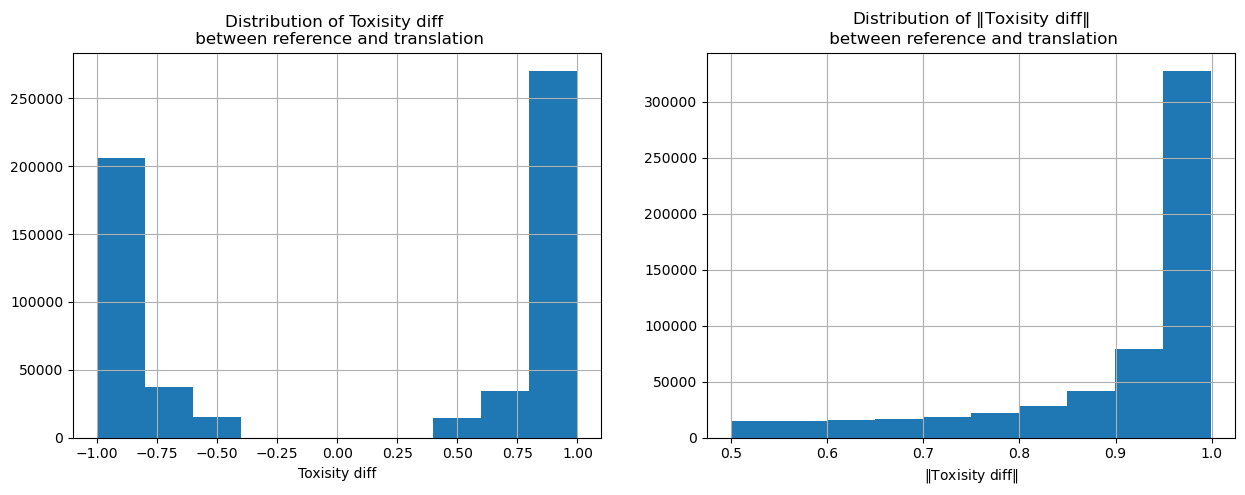

In [6]:
dataset['tox_diff'] = dataset.ref_tox - dataset.trn_tox
dataset['tox_diff_abs'] = np.abs(dataset.ref_tox - dataset.trn_tox)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(dataset['tox_diff'])
axes[0].grid()
axes[0].set_xlabel('Toxisity diff')
axes[0].set_title('Distribution of Toxisity diff \n between reference and translation')
axes[1].hist(dataset['tox_diff_abs'])
axes[1].grid()
axes[1].set_xlabel('$\|$Toxisity diff$\|$')
axes[1].set_title('Distribution of $\|$Toxisity diff$\|$ \n between reference and translation')
plt.show()

In [7]:
dataset['reference_words'] = dataset.apply(lambda x: len(x['reference'].split()), axis=1)
dataset['translation_words'] = dataset.apply(lambda x: len(x['translation'].split()), axis=1)

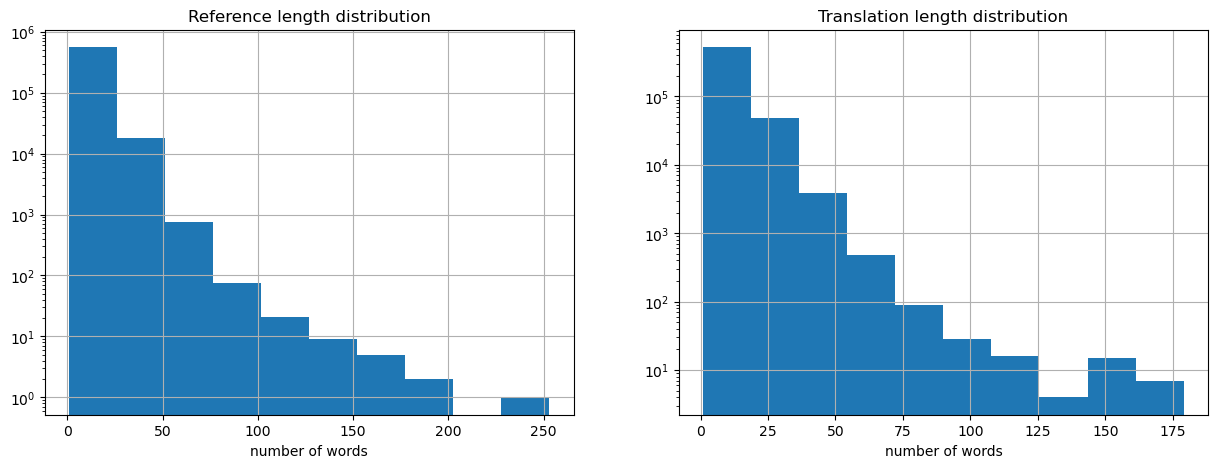

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(dataset['reference_words'])
axes[0].set_yscale('log')
axes[0].grid()
axes[0].set_xlabel('number of words')
axes[0].set_title('Reference length distribution')

axes[1].hist(dataset['translation_words'])
axes[1].set_yscale('log')
axes[1].grid()
axes[1].set_xlabel('number of words')
axes[1].set_title('Translation length distribution')
plt.show()

### Split initial dataset into detoxification and toxification samples

In [9]:
detoxification_samples = dataset[dataset['ref_tox'] >= dataset['trn_tox']]
toxification_samples = dataset[dataset['ref_tox'] < dataset['trn_tox']]

In [10]:
print(f'{len(detoxification_samples) / len(dataset)*100:.3f}% of samples in the initial dataset is text detoxification')
print(f'{len(toxification_samples) / len(dataset)*100:.3f}% of samples in the initial dataset is text toxification')

55.236% of samples in the initial dataset is text detoxification
44.764% of samples in the initial dataset is text toxification


### Analysing datasets for different tasks separately

In [11]:
print(f"Mean reference toxisity - {detoxification_samples['ref_tox'].mean()}")
print(f"Mean translation toxisity - {detoxification_samples['trn_tox'].mean()}")

Mean reference toxisity - 0.9447821251298479
Mean translation toxisity - 0.029131700547454394


In [12]:
print(f"Mean reference toxisity - {toxification_samples['ref_tox'].mean()}")
print(f"Mean translation toxisity - {toxification_samples['trn_tox'].mean()}")

Mean reference toxisity - 0.043584653850167875
Mean translation toxisity - 0.9346804738282111


### Most used words in the toxic examples

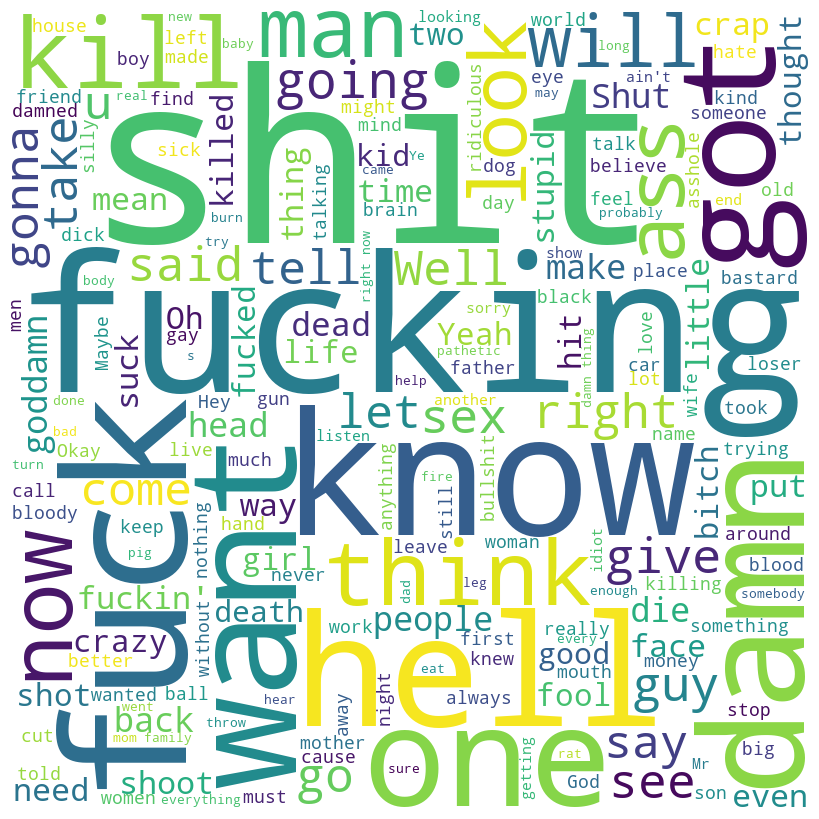

In [27]:
from wordcloud import WordCloud, STOPWORDS
from tqdm.notebook import tqdm

comment_words = ' '.join(detoxification_samples['reference'])

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [13]:
print(f'tox2detox Mean simmilarity: {detoxification_samples["similarity"].mean()}')
print(f'detox2tox Mean simmilarity: {toxification_samples["similarity"].mean()}')

tox2detox Mean simmilarity: 0.7570873176378564
detox2tox Mean simmilarity: 0.7601743716477133


In [14]:
SAVE_PATH = '../data/interim/'
toxification_samples.to_csv(SAVE_PATH + 'toxification_data.csv')
detoxification_samples.to_csv(SAVE_PATH + 'detoxification_data.csv')

### Mergings detoxification and toxification translations into 1 dataste

In [15]:
# rename DataFrame features to make it suitable to detoxication
toxification_samples.columns = [
    "translation",
    "reference",
    "similarity",
    "lenght_diff",
    "trn_tox",
    "ref_tox",
    "tox_diff",
    "tox_diff_abs",
    "translation_words",
    "reference_words",
]

In [16]:
import datasets

tox_dataset = datasets.Dataset.from_pandas(toxification_samples)
detox_dataset = datasets.Dataset.from_pandas(detoxification_samples)

In [17]:
merged_dataset = datasets.concatenate_datasets([tox_dataset, detox_dataset])

In [18]:
np.mean(merged_dataset['ref_tox']), np.mean(merged_dataset['trn_tox'])

(0.94026024110816, 0.03560139314069938)

In [20]:
dataset

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox,tox_diff,tox_diff_abs,reference_words,translation_words
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983,-0.967788,0.967788,15,16
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039,-0.933567,0.933567,4,3
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068,-0.771755,0.771755,8,6
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215,-0.940853,0.940853,9,6
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348,-0.989946,0.989946,7,6
...,...,...,...,...,...,...,...,...,...,...
577772,You didn't know that Estelle had stolen some f...,you didn't know that Estelle stole your fish f...,0.870322,0.030769,0.000121,0.949143,-0.949022,0.949022,12,11
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.722897,0.058824,0.996124,0.215794,0.780331,0.780331,7,7
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.617511,0.212121,0.984538,0.000049,0.984489,0.984489,6,5
577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.679613,0.358209,0.991945,0.000124,0.991822,0.991822,13,10


In [22]:
import huggingface_hub
huggingface_hub.notebook_login()

In [23]:
merged_dataset.push_to_hub('narySt/text_detoxification_dataset')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

### Exploring an existing solution for the text detoxification task

In [24]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

tokenizer = AutoTokenizer.from_pretrained("s-nlp/t5-paranmt-detox")
model = AutoModelForSeq2SeqLM.from_pretrained("s-nlp/t5-paranmt-detox", device_map='auto')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
inputs = tokenizer('The internal policy of the fucking Trump is stupid.', return_tensors='pt')
inputs = {k: v.to(device) for k, v in inputs.items()}
for t in model.generate(**inputs, num_return_sequences=10, do_sample=False, num_beams=10, max_new_tokens=50):
    print(tokenizer.decode(t, skip_special_tokens=True))

the Trump administration's internal policy is nonsense.
the internal policy of Donald Trump is nonsense.
the internal policy of President Trump is nonsense.
the Trump administration's internal policy is crazy.
the president's internal policy is nonsense.
the internal policy of Mr. Trump is nonsense.
the Trump administration's internal policy is stupid.
the internal policy of Trump is nonsense.
the Trump administration's internal policy is bad.
the Trump internal policy is nonsense.
